### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((X_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


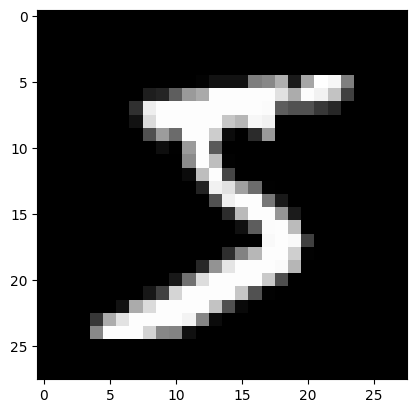

In [3]:
# 784是mnist数据集每个样本的像素点个数，，诶个像素点为28×28=784
from matplotlib import pyplot

pyplot.imshow(X_train[0].reshape((28, 28)), cmap="gray")
print(X_train.shape)

![](https://i.imgur.com/G9Peiff.png)

![](https://i.imgur.com/D5cN7nt.png)

In [4]:
# 注意数据需转换成tensor才能参与后续建模训练
import torch

X_train, y_train, x_valid, y_valid = map(
    torch.tensor, (X_train, y_train, x_valid, y_valid)
)
n, c = X_train.shape
X_train, X_train.shape, y_train.min(), y_train.max()
print(X_train, y_train)
print(X_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [5]:
X_train.shape, y_train.shape

(torch.Size([50000, 784]), torch.Size([50000]))

In [6]:
# torch.nn.functional 很多层和函数在这里都会见到
# torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些
import torch.nn.functional as F

loss_fun = F.cross_entropy


def model(X, weights, bias):
    return X.mm(weights) + bias

In [7]:
batch_size = 64
X = X_train[:batch_size]
y = y_train[:batch_size]

weights = torch.randn([784, 10], dtype=torch.float32, requires_grad=True)
bias = torch.zeros(10, requires_grad=True)

loss_fun(model(X, weights, bias), y)

tensor(11.5085, grad_fn=<NllLossBackward0>)

In [8]:
X.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [9]:
# 创建一个model来更简化代码
# - 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
# - 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
# - Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器
import torch
from torch.nn import Module, Sequential, Linear, ReLU


class Model(Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = Sequential(
            Linear(784, 128),
            ReLU(),
            Linear(128, 256),
            ReLU(),
            Linear(256, 10)
        )

    def forward(self, X):
        return self.model(X)


model = Model()
model

Model(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [10]:
# 可以打印我们定义好名字里的权重和偏置项
for name, parameter in model.named_parameters():
    print(name, parameter, parameter.size())

model.0.weight Parameter containing:
tensor([[ 3.5076e-02, -1.2868e-02, -1.4322e-02,  ..., -1.8779e-02,
         -1.6244e-02, -2.0367e-02],
        [ 6.7713e-03, -2.4848e-02,  4.0217e-04,  ...,  1.4784e-02,
          2.2579e-02, -2.5672e-03],
        [ 2.6382e-02, -1.4209e-02, -2.3449e-02,  ...,  2.6159e-02,
         -5.8772e-03,  3.1374e-04],
        ...,
        [ 6.9920e-05, -2.3099e-03, -2.4268e-02,  ...,  2.0900e-02,
          2.7689e-02, -3.1190e-03],
        [-7.9317e-03, -3.2270e-03,  3.0370e-02,  ...,  1.4918e-02,
          6.0771e-03,  1.6667e-02],
        [ 2.8760e-02,  1.6946e-02, -3.0208e-05,  ..., -4.7814e-04,
          1.2323e-02,  2.2819e-02]], requires_grad=True) torch.Size([128, 784])
model.0.bias Parameter containing:
tensor([ 1.9878e-02,  1.7936e-03, -1.1283e-02, -2.6750e-02,  2.1729e-02,
        -2.0042e-02, -8.5084e-03, -3.0822e-02,  2.6199e-02,  1.6978e-02,
        -3.5667e-02, -1.2968e-03, -3.5672e-02,  1.4293e-02,  2.2649e-02,
         2.5049e-03, -3.0114e-03, 

In [27]:
a = torch.tensor([
    [1, 1, 2, 4],
    [5, 6, 7, 8],
    [3, 2, 1, 0],
    [1, 2, 3, 4]
], dtype=torch.float32)

a = a.reshape((1, 1, 4, 4))
a

tensor([[[[1., 1., 2., 4.],
          [5., 6., 7., 8.],
          [3., 2., 1., 0.],
          [1., 2., 3., 4.]]]])

In [28]:
from torch.nn.functional import max_pool2d

max_pool2d(a, kernel_size=2)

tensor([[[[6., 8.],
          [3., 4.]]]])

In [29]:
from torch.nn.functional import avg_pool2d

avg_pool2d(a, kernel_size=2)

tensor([[[[3.2500, 5.2500],
          [2.0000, 2.0000]]]])